In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import time
import sampler

In [3]:
## Goal 1: Householder
def HouseholdDecomp(B):
    """
    inputs:
    B: np.array
        n x k matrix to be factored (with k <= n)

    returns Q, R
    Q: np.array
        n x k matrix
    R: np.array 
        k x k matrix
    """
    n, k = B.shape
    assert (n >= k), "n < k, precondition violated"
    
    Q = np.eye(n)
    R = B.copy().astype(float)
    for i in range(k):
        v = R[i:n, i].copy()
        v[0] += np.sign(v[0]) * np.linalg.norm(v)
        norm_v = np.linalg.norm(v)
        if norm_v == 0:
            continue
        v = v / norm_v
        v = v[:, None]
        R[i:n,i:k] -= 2 * v @ (v.T @ R[i:n,i:k])
        Q[i:n,:] -= 2 * v @ (v.T @ Q[i:n,:])
        
    Q = Q[:k].T
    R = R[:k]
    assert (Q.shape == (n,k))
    assert (R.shape == (k,k))
    return Q, R

In [4]:
A = np.array([[1, -1, 4], [1, 4, -2], [1, 4, 2], [1, -1, 0]])
Q, R = HouseholdDecomp(A)
print (np.allclose(Q @ R, A, atol=1e-7))

True


In [209]:
## Goal 1: Householder
def Householder_QR_Factorization_(B):
    """
    inputs:
    B: np.array
        n x k matrix to be factored (with k <= n)

    returns Q, R
    Q: np.array
        n x k matrix
    R: np.array 
        k x k matrix
    """
    n, k = B.shape
    R = B.copy()
    H_vecs = []
    for i in range(k):
        x = B[i:, i].copy()
        x_norm = np.linalg.norm(x, ord=2)
        sign = -1 if x[0] < 0 else 1

        alpha = -sign * x_norm
        e1 = np.zeros_like(x)
        e1[0] = 1.0

        u = x - alpha * e1
        norm_u = np.linalg.norm(u)
        if norm_u != 0:
            v = u / norm_u
        else:
            v = u  # no reflection needed if zero vector

        R[i:, i:] = R[i:, i:] - 2 * np.outer(v, v.dot(R[i:, i:]))
        H_vecs.append(v)
        
    return R[:k, :], H_vecs

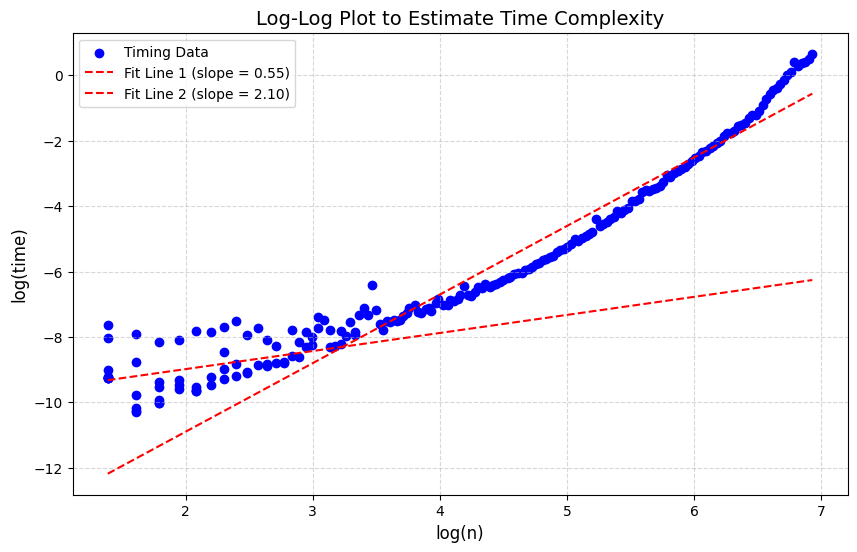

In [204]:
## Goal 1: Testing
test_range = np.logspace(2, 10, num=200, base=2,dtype=int)
times = []

for n in test_range:
    B = np.random.rand(n, n-2)
    
    start_time = time.time()
    Householder_QR_Factorization(B)
    end_time = time.time()
    times.append(end_time - start_time)

# Log-transform the data
log_n = np.log(test_range)
log_time = np.log(times)

# Perform linear regression to estimate slope
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(log_n[:50], log_time[:50])
slope2, intercept2, r_value2, _, _ = scipy.stats.linregress(log_n[50:], log_time[50:])

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(log_n, log_time, label='Timing Data', color='blue')
plt.plot(log_n, intercept1 + slope1 * log_n, label=f'Fit Line 1 (slope = {slope1:.2f})', linestyle='--', color='red')
plt.plot(log_n, intercept2 + slope2 * log_n, label=f'Fit Line 2 (slope = {slope2:.2f})', linestyle='--', color='red')

plt.xlabel('log(n)', fontsize=12)
plt.ylabel('log(time)', fontsize=12)
plt.title('Log-Log Plot to Estimate Time Complexity', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [84]:
# validate QR
#n = 3
#k = 2
#B = np.random.rand(n, k)
n = 4
k = 3
B = np.array([[1, -1, 4], [1, 4, -2], [1, 4, 2], [1, -1, 0]])

R, H_vecs = Householder_QR_Factorization_(B)
print (H_vecs)
# print("B: ", B)
# print("Q: ", Q)
# print("R: ", R)
# print("Q @ R: ", Q @ R)
for i in range(k):
    v = H_vecs[i]
    H = np.eye(n) - 2 * np.outer(v, v.T)
    B = H @ B
    print("H: ", H)

if np.allclose(B, R, rtol=1e-10):
    print("QR factorization is correct")
else:
    print("QR factorization is incorrect")


[array([0.8660254 , 0.28867513, 0.28867513, 0.28867513]), array([ 0.92095348,  0.37803789, -0.09450947]), array([1., 0.])]
H:  [[-0.5        -0.5        -0.5        -0.5       ]
 [-0.5         0.83333333 -0.16666667 -0.16666667]
 [-0.5        -0.16666667  0.83333333 -0.16666667]
 [-0.5        -0.16666667 -0.16666667  0.83333333]]


ValueError: operands could not be broadcast together with shapes (4,4) (3,3) 

In [ ]:

# Sampling functions
def r_square_mat(n: int):
    return np.random.rand(n, n)
def r_diag_mat(n: int):
    return np.diag(np.random.rand(n))
def r_cvec(n: int):
    return np.random.rand(n, 1)
def r_rvec(n: int):
    return np.random.rand(1, n)
# Plotting
def display(n_lo, n_hi, compute, expected = None, samples=500, 
        scientific=False, axx_name="n", axy_name="", **kwargs):
    # Sampling performance
    ns = np.random.randint(n_lo, n_hi, size=samples)
    ns, time = compute(ns)
    scaled_n = np.log(ns)
    scaled_time = np.log(time)

    plt.scatter(scaled_n, scaled_time, s=1)
    # Removing crazy outliers to look better
    t_lo = np.percentile(scaled_time, 1)
    t_hi = np.percentile(scaled_time, 99)
    padding = 0.2 * (t_hi - t_lo)
    t_max = t_hi + padding
    # Line of best fit
    m, b = np.polyfit(scaled_n, scaled_time, 1)
    plt.plot(scaled_n, m * scaled_n + b, 
                color='red', label=f'time={m:.2f}{axx_name} + {b:.2f}', **kwargs)
    ax = plt.gca()
    if (not scientific):
        ax.ticklabel_format(useOffset=False, style='plain')
    plt.xlabel(axx_name)
    plt.ylabel(axy_name)
    plt.ylim((0, t_max))
    plt.legend()
    plt.show()

In [ ]:
def compute(ns):
    times = []
    for n in ns:
        B = r_square_mat(n)
        start = time.time()
        Householder_QR_Factorization(B)
        end = time.time()
        times.append(end - start)
    return ns, times



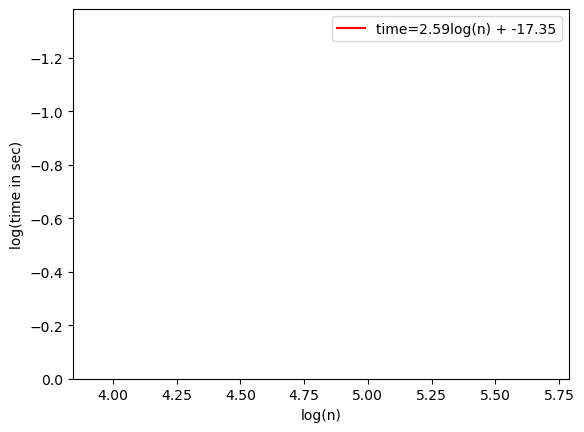

In [77]:
display(n_lo=50, n_hi=300, compute=compute, samples=250,
axx_name="log(n)", axy_name="log(time in sec)",
scientific=False)
